# Using simple NLP, TfidfVectorizer to cluster "Summary" column

Goal of this project is to cluster "Summary" column in orded to understand different reasons for airplane crashes, I created 10 clusters and after analysing them I extraced different reasons for crashes listed bellow.

## These are the cluster created:
- Cluster 0: Mountain crash in poor weather conditions
- Cluster 1: Unknown cause of crash
- Cluster 2: Engine failure
- Cluster 3: Crash on landing
- Cluster 4: Poor weather conditions/visibility
- Cluster 5: Cause of crash missing
- Cluster 6: Undetermined crash on route
- Cluster 7: Crash of cargo plane
- Cluster 8: Crash on the takeoff
- Cluster 9: Pilot lost controll


It is not perfect and there is much more work to do. I should probably explore some different and more complex NLP alghorithms or classifiers.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
from datetime import date, timedelta, datetime

#import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# read dataset
data = pd.read_csv("/kaggle/input/airplane-crashes-since-1908-csv/Airplane_Crashes_Since_1908.csv")

In [3]:
pd.set_option('display.max_colwidth', 50)
data

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,05/20/2009,06:30,"Near Madiun, Indonesia",Military - Indonesian Air Force,NaN,Jakarta - Maduin,Lockheed C-130 Hercules,A-1325,1982,112.0,98.0,2.0,"While on approach, the military transport cras..."
5264,05/26/2009,NaN,"Near Isiro, DemocratiRepubliCongo",Service Air,NaN,Goma - Isiro,Antonov An-26,9Q-CSA,5005,4.0,4.0,NaN,The cargo plane crashed while on approach to I...
5265,06/01/2009,00:15,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,447,Rio de Janeiro - Paris,Airbus A330-203,F-GZCP,660,228.0,228.0,0.0,The Airbus went missing over the AtlantiOcean ...
5266,06/07/2009,08:30,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,NaN,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,C-FJJR,424,1.0,1.0,0.0,The air ambulance crashed into hills while att...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3561 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
dtypes: float64(3), object(10)
memory usage: 535.2+ KB


<Axes: >

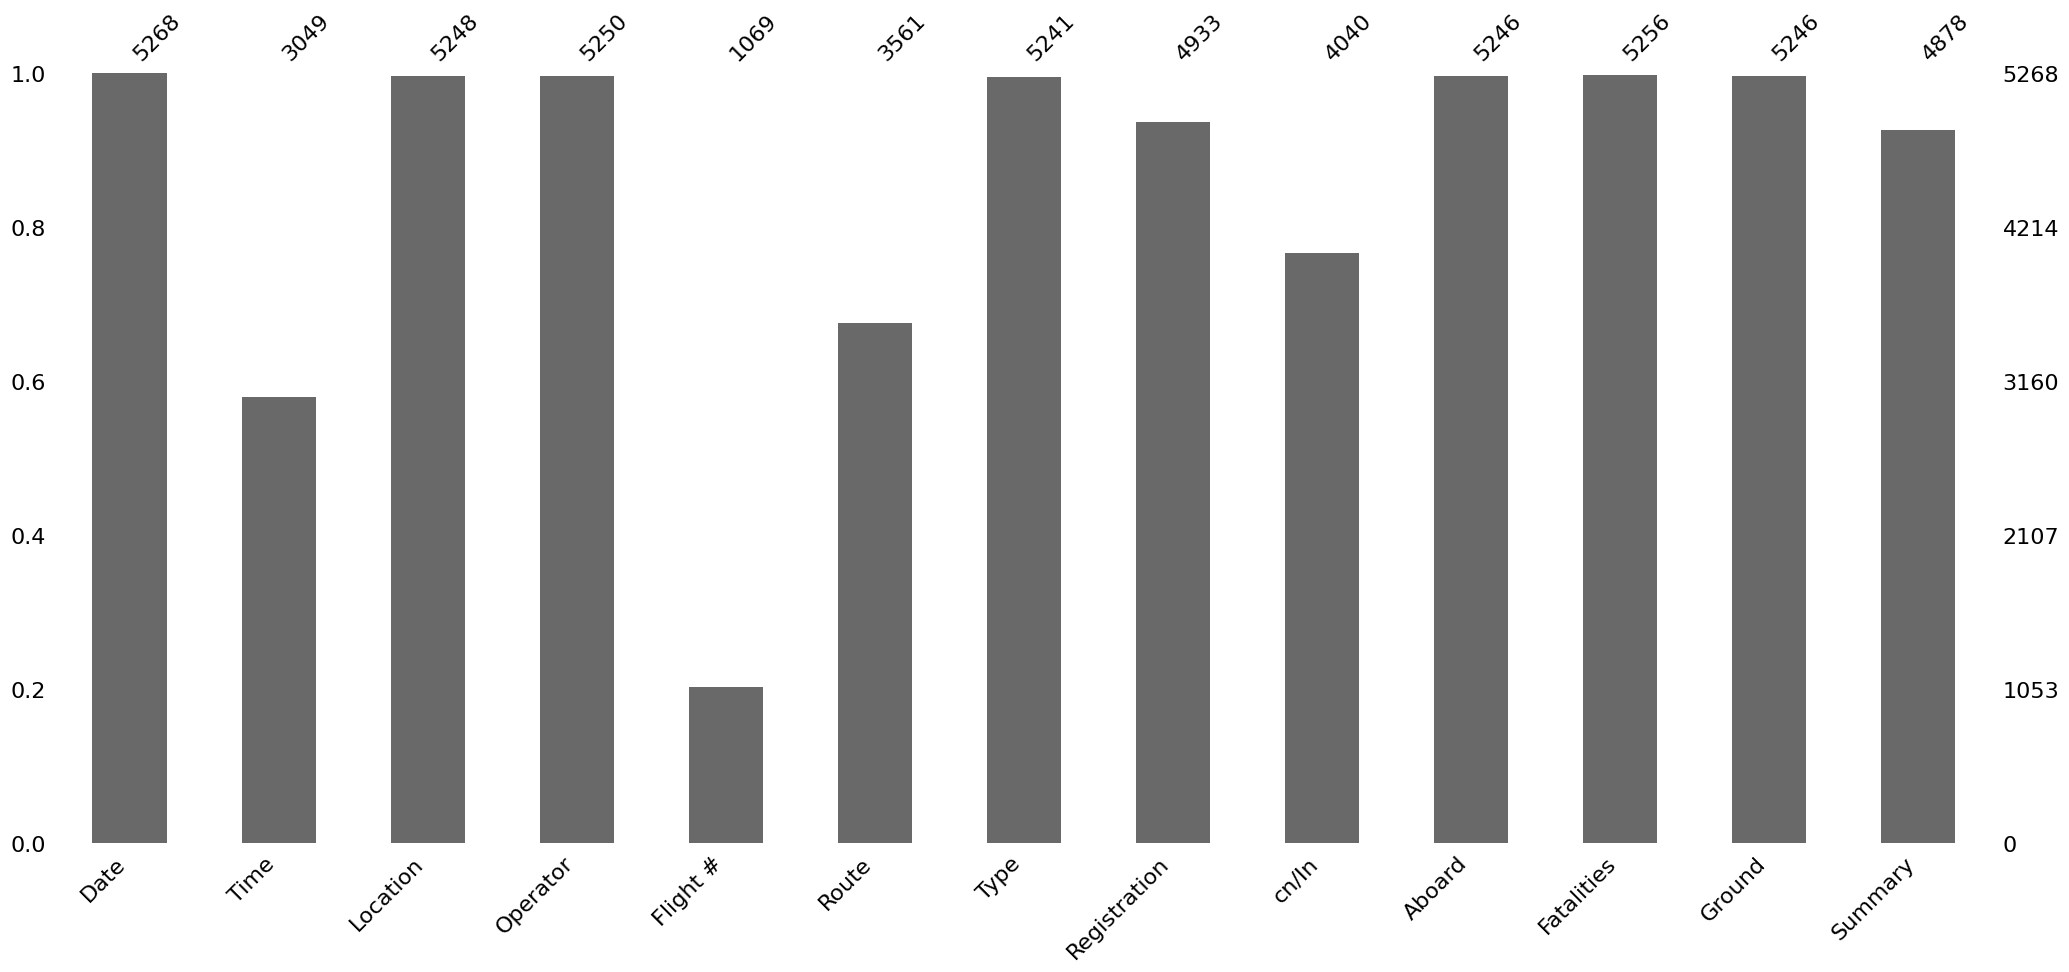

In [5]:
msno.bar(data)

In [6]:
#cleanup
data['Time'] = data['Time'].replace(np.nan, '00:00') 
data['Time'] = data['Time'].str.replace('c: ', '')
data['Time'] = data['Time'].str.replace('c:', '')
data['Time'] = data['Time'].str.replace('c', '')
data['Time'] = data['Time'].str.replace('12\'20', '12:20')
data['Time'] = data['Time'].str.replace('18.40', '18:40')
data['Time'] = data['Time'].str.replace('0943', '09:43')
data['Time'] = data['Time'].str.replace('22\'08', '22:08')
data['Time'] = data['Time'].str.replace('114:20', '00:00')


data['Time'] = data['Date'] + ' ' + data['Time'] #joining two rows
def todate(x):
    return datetime.strptime(x, '%m/%d/%Y %H:%M')
data['Time'] = data['Time'].apply(todate) #convert to date type
print('Date ranges from ' + str(data.Time.min()) + ' to ' + str(data.Time.max())) 

data.Operator = data.Operator.str.upper() #to avoid duplicates.

Date ranges from 1908-09-17 17:18:00 to 2009-06-08 00:00:00


In [7]:
# Define the function to extract time components
def extract_time_components(time_str):
    time_obj = pd.to_datetime(time_str)
    decade = time_obj.year // 10 * 10
    year = time_obj.year
    month = time_obj.month
    week = time_obj.isocalendar()[1]  # ISO week number
    season = (month % 12 + 3) // 3  # 1: Winter, 2: Spring, 3: Summer, 4: Autumn
    day = time_obj.strftime('%A')  # Full weekday name
    hour = time_obj.hour
    minute = time_obj.minute
    am_pm = 'AM' if time_obj.hour < 12 else 'PM'
    night_day = "night" if time_obj.hour >= 18 or time_obj.hour <= 6 else "day"
    return decade, year, month, week, season, day, hour, minute, am_pm, night_day

# Apply the function to the 'time' column to extract time components
time_components = data['Time'].apply(extract_time_components)

# Assign the extracted time components to new columns in the DataFrame
data[['Decade', 'Year', 'Month', 'Week', 'Season', 'Day', 'Hour', 'Minute', 'AM/PM', "night_day"]] = pd.DataFrame(time_components.tolist(), index=data.index)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5268 non-null   object        
 1   Time          5268 non-null   datetime64[ns]
 2   Location      5248 non-null   object        
 3   Operator      5250 non-null   object        
 4   Flight #      1069 non-null   object        
 5   Route         3561 non-null   object        
 6   Type          5241 non-null   object        
 7   Registration  4933 non-null   object        
 8   cn/In         4040 non-null   object        
 9   Aboard        5246 non-null   float64       
 10  Fatalities    5256 non-null   float64       
 11  Ground        5246 non-null   float64       
 12  Summary       4878 non-null   object        
 13  Decade        5268 non-null   int64         
 14  Year          5268 non-null   int64         
 15  Month         5268 non-null   int64   

In [9]:
# fill in missing values for "Summary" column
data["Summary"].fillna("Cause is unknown.", inplace = True)

/tmp/ipykernel_17/1338194617.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Summary"].fillna("Cause is unknown.", inplace = True)


In [10]:
# Convert to lower-case
data["Summary"] = data["Summary"].str.lower()

In [11]:
data["Summary"]

0       during a demonstration flight, a u.s. army fly...
1       first u.s. dirigible akron exploded just offsh...
2       the first fatal airplane accident in canada oc...
3       the airship flew into a thunderstorm and encou...
4       hydrogen gas which was being vented was sucked...
                              ...                        
5263    while on approach, the military transport cras...
5264    the cargo plane crashed while on approach to i...
5265    the airbus went missing over the atlantiocean ...
5266    the air ambulance crashed into hills while att...
5267    the military transport went missing while en r...
Name: Summary, Length: 5268, dtype: object

In [12]:
# Get the English stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Remove special characters and digits using regular expressions
    clean_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the cleaned text
    word_tokens = word_tokenize(clean_text)
    # Remove stop words
    filtered_tokens = [word for word in word_tokens if word.lower() not in stop_words]
    # Join the filtered tokens back into a single string
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Apply the function to the "Summary" column
data["Summary"] = data["Summary"].apply(remove_stopwords)



In [13]:
set_sd = {"ahoj", "zmrde"}

In [14]:
type(set_sd)

set

In [15]:
plus_set = stop_words.union(set_sd)

In [16]:
data["Summary"]

0       demonstration flight us army flyer flown orvil...
1       first us dirigible akron exploded offshore alt...
2       first fatal airplane accident canada occurred ...
3       airship flew thunderstorm encountered severe d...
4       hydrogen gas vented sucked forward engine igni...
                              ...                        
5263    approach military transport crashed houses ski...
5264     cargo plane crashed approach isiromatari airport
5265    airbus went missing atlantiocean flight rio de...
5266    air ambulance crashed hills attempting land he...
5267    military transport went missing en route might...
Name: Summary, Length: 5268, dtype: object

In [17]:
# create list of all strings
data["tokens"] = data["Summary"].apply(word_tokenize)

all_tokens = [token for sublist in data["tokens"] for token in sublist]

# Count the frequencies of each token
token_freq = Counter(all_tokens)

# Print the most common tokens and their frequencies
for token, freq in token_freq.most_common()[:20]:
    print(f"{token}: {freq}")

crashed: 3214
aircraft: 2389
plane: 1835
flight: 1050
pilot: 1013
approach: 941
engine: 923
runway: 914
failure: 878
crew: 751
landing: 732
airport: 624
weather: 605
altitude: 598
cause: 576
takeoff: 574
mountain: 559
conditions: 540
taking: 534
land: 522


In [18]:
# Count the occurrences of each word in the entire dataset
from collections import defaultdict
word_counts = defaultdict(int)
for tokens in data["tokens"]:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        word_counts[token] += 1

# Sort the dictionary by values in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Assign the top 5 words to a new column in the DataFrame for each row
data["top_20"] = ""

# Iterate through each row and assign the top 20 words
for idx, row in data.iterrows():
    word_freq = {}
    for token in row["tokens"]:
        if token not in word_freq:
            word_freq[token] = word_counts[token]
    sorted_word_counts_row = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    top_5_row = [word for word, _ in sorted_word_counts_row[:20]]
    data.at[idx, "top_20"] = top_5_row


In [19]:
data["top_20"].value_counts()[:40]

top_20
[cause, unknown]                                  390
[crashed, takeoff]                                 28
[crashed, route, en]                               22
[crashed, approach]                                14
[crashed, mountain]                                13
[mountain, struck]                                 12
[crashed, sea]                                     12
[crashed, mountain, route, en]                     11
[crashed, taking, shortly]                         10
[mountain, flew]                                    8
[pilot, error]                                      7
[failure, engine]                                   7
[plane, cargo]                                      7
[route, en, disappeared]                            6
[crashed, plane, cargo]                             6
[weather, related]                                  6
[crashed, landing]                                  5
[crashed, land, attempting]                         5
[crashed, mountains] 

In [20]:
# replace "Summary" with "top_20"
data["Summary"] = data["top_20"]
for idx, row in data.iterrows():
    joined = " ".join(row["Summary"])
    data.at[idx, "Summary"] = joined
data.drop(columns = ["tokens", "top_20"], inplace = True)
data["Summary"].value_counts()[:20]

Summary
cause unknown                390
crashed takeoff               28
crashed route en              22
crashed approach              14
crashed mountain              13
mountain struck               12
crashed sea                   12
crashed mountain route en     11
crashed taking shortly        10
mountain flew                  8
pilot error                    7
failure engine                 7
plane cargo                    7
route en disappeared           6
crashed plane cargo            6
weather related                6
crashed landing                5
crashed land attempting        5
crashed mountains              5
crashed ocean                  4
Name: count, dtype: int64

In [21]:
# try different vectorizers
#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()

# Fit and transform the text data
X = vectorizer.fit_transform(data["Summary"])

# Convert the transformed data into a DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [22]:
tfidf_df.describe()

,aad,abandon,abandoned,abandoning,abandonment,abidjan,abilities,ability,abingdon,abkhazi,...,yuri,zadax,zambian,zero,zerozero,zimathan,zkdqf,zlat,zone,zuma
count,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,...,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000
mean,0.000063,0.000077,0.000311,0.000063,0.000075,0.000122,0.000077,0.000256,0.000069,0.000238,...,0.000060,0.000094,0.000072,0.000426,0.000080,0.000116,0.000094,0.000075,0.000065,0.000102
std,0.004558,0.005574,0.010155,0.004607,0.005423,0.008868,0.005568,0.009321,0.004993,0.012402,...,0.004359,0.006842,0.005190,0.014905,0.005797,0.008447,0.006842,0.005410,0.004748,0.007389
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.330813,0.404597,0.390955,0.334359,0.393593,0.643631,0.404146,0.361189,0.362421,0.732765,...,0.316395,0.496604,0.376680,0.805488,0.420718,0.613114,0.496604,0.392678,0.344647,0.536268


In [23]:
from sklearn.decomposition import PCA

pca = PCA()

# Fit PCA to the TF-IDF data
pca.fit(tfidf_df)

# Apply PCA transformation to the TF-IDF data
X_pca = pca.transform(tfidf_df)

In [24]:
# Calculate the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Number of components to capture 90% of the variance
n_components_90 = (cumulative_variance_ratio < 0.90).sum() + 1  # Add 1 because of zero-based indexing

# Number of components to capture 95% of the variance
n_components_95 = (cumulative_variance_ratio < 0.95).sum() + 1

# Number of components to capture 99% of the variance
n_components_99 = (cumulative_variance_ratio < 0.99).sum() + 1

print("Number of components to capture 90% of the variance:", n_components_90)
print("Number of components to capture 95% of the variance:", n_components_95)
print("Number of components to capture 99% of the variance:", n_components_99)

Number of components to capture 90% of the variance: 1277
Number of components to capture 95% of the variance: 1775
Number of components to capture 99% of the variance: 2528


In [25]:
pca_df = pd.DataFrame(X_pca[:, :2527])
from sklearn.cluster import KMeans

# Initialize KMeans with 10 clusters
kmeans = KMeans(n_clusters=10, max_iter = 1000, random_state = 42, algorithm = "elkan")

# Fit KMeans to the PCA-transformed data
kmeans.fit(pca_df)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the pca_df DataFrame
pca_df['k_cluster'] = cluster_labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
pca_df["k_cluster"].value_counts()

k_cluster
9    2206
3     560
8     551
0     408
2     392
4     292
7     270
6     244
1     228
5     117
Name: count, dtype: int64

In [27]:
data['k_cluster'] = pca_df['k_cluster']

In [28]:
# check different clusters
pd.set_option('display.max_colwidth', 500)
data[data["k_cluster"] == 9]["Summary"][:20]

0        aircraft flight ground control short loss feet two one time causing airplane first height passenger later approximately killing separated suffered
1                                                                                        flight altitude ft first exploded us test offshore dirigible akron
2                                                  accident killed airplane first occurred american john california fatal canada aviator barnstormer bryant
3     miles control two sea flew broke severe thunderstorm north island crashing encountered sank immediately downdraft car occupants ship airship drowning
4                                                                         engine ft causing forward ignited gas sucked airship vented explode burn hydrogen
6                                                                                 burned near exploded island lightning ignited gas vented hydrogen neuwerk
7                                                               

In [29]:
# check the mean lenght of characters of all clusters
mean_length_by_cluster = data.groupby('k_cluster')['Summary'].apply(lambda x: x.str.len().mean())

print(mean_length_by_cluster.sort_values())

k_cluster
2     13.109694
5     29.726496
1     44.798246
6     76.049180
9     92.375340
4     94.746575
0     97.227941
8    102.862069
7    111.407407
3    114.846429
Name: Summary, dtype: float64


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5268 non-null   object        
 1   Time          5268 non-null   datetime64[ns]
 2   Location      5248 non-null   object        
 3   Operator      5250 non-null   object        
 4   Flight #      1069 non-null   object        
 5   Route         3561 non-null   object        
 6   Type          5241 non-null   object        
 7   Registration  4933 non-null   object        
 8   cn/In         4040 non-null   object        
 9   Aboard        5246 non-null   float64       
 10  Fatalities    5256 non-null   float64       
 11  Ground        5246 non-null   float64       
 12  Summary       5268 non-null   object        
 13  Decade        5268 non-null   int64         
 14  Year          5268 non-null   int64         
 15  Month         5268 non-null   int64   

In [31]:
data_pred = data.copy(deep = True)

In [32]:
# drop not-needed columns
data_pred.drop(columns = ["Date", "Time", "Location", "Operator", "Flight #", "Route", "Type",
                         "Registration", "cn/In", "Ground", "Summary", "Year", "Month", "Week", "Day",
                         "Hour", "Minute"], inplace = True)

In [33]:
# fill in missing values with median
data_pred['Fatalities'].fillna(data_pred['Fatalities'].median(), inplace=True)
data_pred['Aboard'].fillna(data_pred['Aboard'].median(), inplace=True)

/tmp/ipykernel_17/3511157794.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_pred['Fatalities'].fillna(data_pred['Fatalities'].median(), inplace=True)
/tmp/ipykernel_17/3511157794.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [34]:
data_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Aboard      5268 non-null   float64
 1   Fatalities  5268 non-null   float64
 2   Decade      5268 non-null   int64  
 3   Season      5268 non-null   int64  
 4   AM/PM       5268 non-null   object 
 5   night_day   5268 non-null   object 
 6   k_cluster   5268 non-null   int32  
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 267.6+ KB


In [35]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()


# Fit and transform the "AM/PM" column
data_pred['AM/PM_encoded'] = label_encoder.fit_transform(data_pred['AM/PM'])
# Store the mapping of original labels to encoded labels
am_pm_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Fit and transform the "night_day" column
data_pred['night_day_encoded'] = label_encoder.fit_transform(data_pred['night_day'])
# Store the mapping of original labels to encoded labels
night_day_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Fit and transform the "AM/PM" column
data_pred['decade_encoded'] = label_encoder.fit_transform(data_pred['Decade'])
# Store the mapping of original labels to encoded labels
decade_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


data_pred.drop(columns = ["AM/PM", "night_day", "Decade"], inplace = True)

In [36]:
data_pred

,Aboard,Fatalities,Season,k_cluster,AM/PM_encoded,night_day_encoded,decade_encoded
0,2.0,1.0,4,9,1,0,0
1,5.0,5.0,3,9,0,1,1
2,1.0,1.0,3,9,0,1,1
3,20.0,14.0,4,9,1,1,1
4,30.0,30.0,4,9,0,0,1
...,...,...,...,...,...,...,...
5263,112.0,98.0,2,9,0,1,10
5264,4.0,4.0,2,8,0,1,10
5265,228.0,228.0,3,9,0,1,10
5266,1.0,1.0,3,4,0,0,10


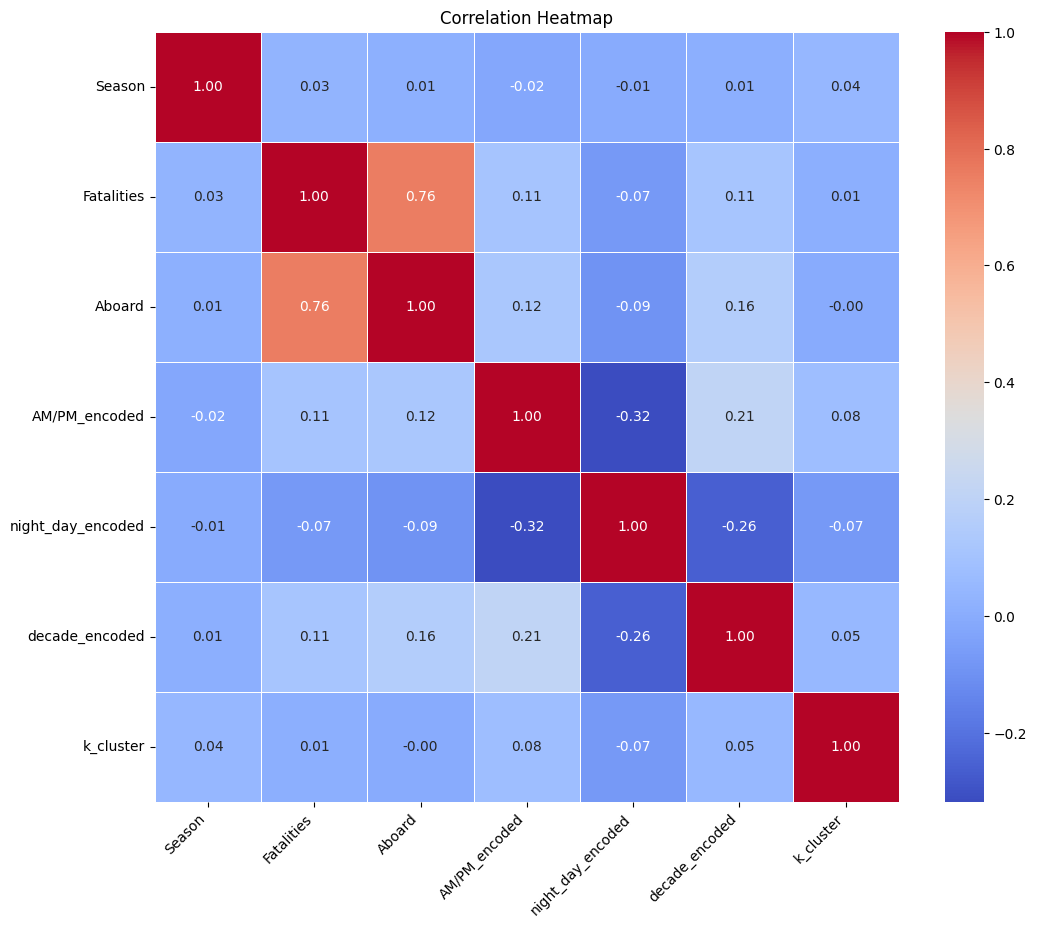

In [37]:
# Plot correlation heatmap of the features used for model creation
# Select the specified columns
selected_columns = ["Season", "Fatalities", "Aboard", "AM/PM_encoded", "night_day_encoded", "decade_encoded", "k_cluster"]

# Calculate the correlation matrix
correlation_matrix = data_pred[selected_columns].corr()

# Set up the heatmap plot
plt.figure(figsize=(12, 10))  # Adjust the figure size to accommodate the x-axis labels
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a title
plt.title('Correlation Heatmap')

# Save the plot as an image file
plt.savefig('correlation_heatmap.png', bbox_inches='tight')  # Use bbox_inches='tight' to prevent clipping

# Display the plot
plt.show()

In [38]:
correlation_matrix["k_cluster"]

Season               0.043480
Fatalities           0.006244
Aboard              -0.004755
AM/PM_encoded        0.076292
night_day_encoded   -0.074126
decade_encoded       0.052041
k_cluster            1.000000
Name: k_cluster, dtype: float64

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [40]:
from sklearn.preprocessing import StandardScaler

# scale the features
scaler = StandardScaler()
y = data_pred["k_cluster"]
X = data_pred[["Season", "Fatalities", "Aboard", "AM/PM_encoded", "night_day_encoded", "decade_encoded"]]

X = scaler.fit_transform(X)

In [41]:
X = pd.DataFrame(X, columns = ["Season", "Fatalities_bins", "Aboard_bins", "AM/PM_encoded", "night_day_encoded", "decade_encoded"])

In [42]:
X

,Season,Fatalities_bins,Aboard_bins,AM/PM_encoded,night_day_encoded,decade_encoded
0,1.316945,-0.574224,-0.592977,1.399246,-1.404604,-2.953990
1,0.441198,-0.453608,-0.523198,-0.714671,0.711945,-2.510614
2,0.441198,-0.574224,-0.616236,-0.714671,0.711945,-2.510614
3,1.316945,-0.182223,-0.174302,1.399246,0.711945,-2.510614
4,1.316945,0.300240,0.058295,-0.714671,-1.404604,-2.510614
...,...,...,...,...,...,...
5263,-0.434549,2.350708,1.965590,-0.714671,0.711945,1.479772
5264,-0.434549,-0.483762,-0.546457,-0.714671,0.711945,1.479772
5265,0.441198,6.270720,4.663715,-0.714671,0.711945,1.479772
5266,0.441198,-0.574224,-0.616236,-0.714671,-1.404604,1.479772


In [43]:
# Compare model to see how various different models perform with default parameters
def get_classifiers_scores(X, y):
    models = [RandomForestClassifier(random_state = 42), 
                   GradientBoostingClassifier(random_state = 42), 
                   AdaBoostClassifier(random_state = 42), 
                   BaggingClassifier(random_state = 42),
                   ExtraTreesClassifier(random_state = 42),
                   HistGradientBoostingClassifier(random_state = 42),
                   DecisionTreeClassifier(random_state = 42),
                   SVC(kernel = "linear", random_state = 42),
                   XGBClassifier(random_state = 42),
                   LogisticRegression(random_state = 42, max_iter=1000)]
    classifiers = ["RandomForestClassifier",
                   "GradientBoostingClassifier",
                   "AdaBoostClassifier",
                   "BaggingClassifier",
                   "ExtraTreesClassifier",
                   "HistGradientBoostingClassifier",
                   "DecisionTreeClassifier",
                   "SVC",
                   "xgb",
                   "LogisticRegression"]

    cv_mean = []
    cv_std = []

    for model in models:
        model = model
        cv = cross_val_score(model,X,y,cv=10, scoring='accuracy', verbose = 1, n_jobs=-1)
        cv_std.append(cv.std())
        cv_mean.append(cv.mean())

    cv_dataframe = pd.DataFrame({"CV Mean": cv_mean,"Std": cv_std}, index = classifiers)       
    cv_dataframe = cv_dataframe.sort_values(by = ["CV Mean"], ascending = False)
    return cv_dataframe

In [44]:
# predict cluster classes with different classifiers
get_classifiers_scores(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

,CV Mean,Std
LogisticRegression,0.410593,0.080480
SVC,0.395984,0.068115
AdaBoostClassifier,0.349097,0.106347
GradientBoostingClassifier,0.263831,0.112781
xgb,0.229668,0.091541
HistGradientBoostingClassifier,0.227197,0.091406
RandomForestClassifier,0.222837,0.070100
ExtraTreesClassifier,0.204804,0.044617
BaggingClassifier,0.192088,0.062260
DecisionTreeClassifier,0.171025,0.045175
